# Using several classifiers and tuning parameters - Parameters grid
1. import a sample dataset 
1. do the usual preliminary data explorations and separate the predicting attributes from the *target* `'Exited'`
1. define the _models_ that will be tested and prepare the _hyperparameter ranges_ for the modules
1. set the list of *score functions* to choose from
1. split the dataset into two parts: train and test
1. Loop on score functions and, for each score, loop on the model labels (see details below)
    - optimize with GridSearchCV
    - test
    - store the results of best model
1. for each scoring show the best models for each classifier, sorted by decreasing performance
1. for each scoring show the confusion matrix of the prediction given by the best model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# 0. Initial settings

In [2]:
ts = 0.3 # test size
random_state = 42
np.random.seed(random_state)
cv = 3   # number of cross-validation splits

# 1. Import the dataset

In [3]:
data = "churn-analysis.csv"
df = pd.read_csv(data, sep=",")
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,True
1,502,0,42,8,159660.80,3,1,0,113931.57,True
2,699,0,39,1,0.00,2,0,0,93826.63,False
3,822,1,50,7,0.00,2,1,1,10062.80,False
4,501,1,44,4,142051.07,2,0,1,74940.50,False


# 2. Explore the data

The output of exploration is not shown here

In [4]:
df.value_counts('Exited')

Exited
False    4204
True      810
Name: count, dtype: int64

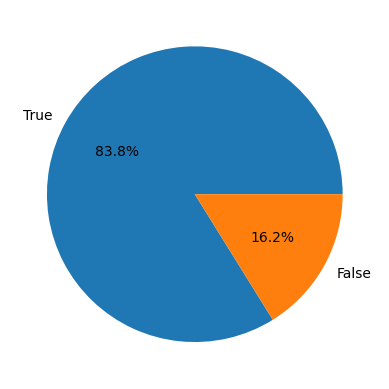

In [5]:
fig, ax = plt.subplots()
ax.pie(df['Exited'].value_counts(), labels = df['Exited'].unique(),autopct='%1.1f%%');

# 3. Define the _models_ 
Prepare the _hyperparameter ranges_ for the modules

Put everything in a dictionary, for ease of use

In [11]:
model_lbls = ['dt' # decision tree
             ,'nb' # gaussian naive bayes
             ,'lp'   # linear perceptron
      #        ,'svc'  # support vector # deactivate if running time becomes too long
             ,'knn'  # k nearest neighbours
             ,'adb'  # adaboost
             ,'rf'   # random forest
            ]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    #'svc':{'name': 'Support Vector      ',
     #      'estimator': SVC(random_state=random_state), 
      #     'param': [{'kernel': ['rbf'], 
       #             'gamma': [1e-3, 1e-4],
        #            'C': [1, 10, 100],
         #           },
          #          {'kernel': ['linear'],
           #          'C': [1, 10, 100],                     
            # },
             #      ]},
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[10,20,30,40,50]
                     ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,60,10)]}]
          }

}

# 4. Set the list of *score functions* to choose from

In [9]:
scores = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# 5. Split the dataset into the train and test parts

In [6]:
X=df.drop(columns='Exited')
X
y=df['Exited']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = ts, random_state = random_state)
Xtrain, Xtest, ytrain, ytest

(      CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
 2304          681       1   25       5       0.00              1          0   
 1609          611       1   58       8       0.00              2          0   
 1238          850       1   42       0       0.00              2          1   
 903           760       0   32       7       0.00              2          1   
 2521          709       1   38       5       0.00              2          1   
 ...           ...     ...  ...     ...        ...            ...        ...   
 4426          832       0   29       5       0.00              2          1   
 466           544       1   37       3   84496.71              1          0   
 3092          704       1   36       3  114370.41              1          0   
 3772          586       1   58       7  151933.63              1          1   
 860           622       1   38       5       0.00              2          0   
 
       IsActiveMember  EstimatedSalary

# 6. Loop on scores and, for each score, loop on the model labels

The function `GridSearchCV` iterates a cross validation experiment to train and test a model with different combinations of paramater values
- for each parameter we have set before a list of values to test, `ParametersGrid` will be implicitly called to generate all the combinations
- we choose a *score function* which will be used for the optimization
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](https://scikit-learn.org/stable/modules/model_evaluation.html) for reference
- the output is a dataframe containing 
    - the set of parameters maximising the score 
    - the score used for optimisation and all the test scores

### Steps

- prepare an empty list `clfs` to store all the fitte models
- prepare an empty DataFrame which will collect the results of the fittings with each combination of parameters
    - dataframe columns are `'scoring','model','best_params','accuracy','precision_macro','recall_macro','f1_macro'`
- loop

In [7]:
clfs = []
results = pd.DataFrame(columns=['scoring','model','best_params','accuracy','precision_macro','recall_macro','f1_macro'])

### Parameters to collect

`classification_report` produces a dictionary containing some classification performance measures, given the *ground truth* and the *predictions* (use the parameter `output_dict=True`)

The measures are (among others):
- `accuracy`
- `macro avg` a dictionary containing:
    - `precision`
    - `recall`
    - `f1-score`
- ...


### Loop

- repeat for all the chosen scorings
    - repeat for all the chosen classification models
        - store in `clf` the initialisation of `GridSearchCV` with the appropriate
            - classification model
            - parameters ranges
            - scoring
            - cross validation method `cv` (the same for all)
        - fit `clf` with the *train* part of `X` and `y`
        - store in `y_pred` the prediction for the *test* part of `X`
        - append `clf` to clfs`
        - append `y_pred` to `y_preds`
        - store in variable `cr` the `classification_report` produced with the test part of `y` and `y_pred`
        - store in the last row of `results` a list containing:
            - the name of the model
            - the `.best_params_` of `clf`
            - a selection of the contents of cr
                - 'accuracy', 
                - 'macro avg''precision'
                - 'macro avg''recall'
                - 'macro avg''f1-score'

In [12]:
for score in scores:
    for model_name, model_params in models.items():
        clf = GridSearchCV(estimator=model_params['estimator'], param_grid=model_params['param'], cv = cv, scoring=score)
        clf.fit(Xtrain, ytrain)
        y_pred = clf.predict(Xtest)   
        cr = classification_report(ytest, y_pred, output_dict=True)
        results.loc[len(results)] = {
            'scoring': score,
            'model': model_name,
            'best_params': clf.best_params_,
            'accuracy': cr['accuracy'],
            'precision_macro': cr['macro avg']['precision'],
            'recall_macro': cr['macro avg']['recall'],
            'f1_macro': cr['macro avg']['f1-score']
        }

C:\Users\15702\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15702\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15702\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

In [13]:
results


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
0,accuracy,dt,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
1,accuracy,nb,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
2,accuracy,lp,"{'class_weight': None, 'early_stopping': True}",0.827243,0.413621,0.500000,0.452727
3,accuracy,knn,{'n_neighbors': 6},0.820598,0.525032,0.502070,0.464974
4,accuracy,adb,"{'learning_rate': 0.5, 'n_estimators': 30}",0.879734,0.853044,0.685395,0.729258
5,accuracy,rf,"{'max_depth': 7, 'n_estimators': 30}",0.879070,0.877186,0.669779,0.715608
6,precision_macro,dt,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
7,precision_macro,nb,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
8,precision_macro,lp,"{'class_weight': 'balanced', 'early_stopping':...",0.174751,0.586551,0.501205,0.149963
9,precision_macro,knn,{'n_neighbors': 6},0.820598,0.525032,0.502070,0.464974


# 7. Display

For each scoring show the ranking of the models, and the confusion matrix given by the best model

For each scoring:
- set a `scoring_filter`
- filter the results of that scoring
- display the filtered dataframe with the `display()` function (it allows several displays of dataframes )



In [14]:
for score in scores:
    scoring_filter = results['scoring'] == score
    scoring_results = results[scoring_filter].sort_values(by=score, ascending=False)
    print(f"Scoring Results for Scoring Metric: {scores}")
    display(scoring_results)

Scoring Results for Scoring Metric: ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
4,accuracy,adb,"{'learning_rate': 0.5, 'n_estimators': 30}",0.879734,0.853044,0.685395,0.729258
5,accuracy,rf,"{'max_depth': 7, 'n_estimators': 30}",0.879070,0.877186,0.669779,0.715608
0,accuracy,dt,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
1,accuracy,nb,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
2,accuracy,lp,"{'class_weight': None, 'early_stopping': True}",0.827243,0.413621,0.500000,0.452727
3,accuracy,knn,{'n_neighbors': 6},0.820598,0.525032,0.502070,0.464974


Scoring Results for Scoring Metric: ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
11,precision_macro,rf,"{'max_depth': 4, 'n_estimators': 20}",0.871096,0.895666,0.636052,0.676715
10,precision_macro,adb,"{'learning_rate': 0.2, 'n_estimators': 20}",0.841860,0.881755,0.545351,0.540230
7,precision_macro,nb,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
6,precision_macro,dt,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
8,precision_macro,lp,"{'class_weight': 'balanced', 'early_stopping':...",0.174751,0.586551,0.501205,0.149963
9,precision_macro,knn,{'n_neighbors': 6},0.820598,0.525032,0.502070,0.464974


Scoring Results for Scoring Metric: ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
12,recall_macro,dt,"{'class_weight': 'balanced', 'max_depth': 4}",0.724252,0.649313,0.743567,0.651403
16,recall_macro,adb,"{'learning_rate': 1.25, 'n_estimators': 10}",0.874419,0.811279,0.698919,0.734798
17,recall_macro,rf,"{'max_depth': 9, 'n_estimators': 20}",0.880399,0.854085,0.687319,0.731352
13,recall_macro,nb,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
15,recall_macro,knn,{'n_neighbors': 1},0.728239,0.523914,0.523842,0.523877
14,recall_macro,lp,"{'class_weight': 'balanced', 'early_stopping':...",0.260465,0.503507,0.502804,0.259208


Scoring Results for Scoring Metric: ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
22,f1_macro,adb,"{'learning_rate': 1.25, 'n_estimators': 10}",0.874419,0.811279,0.698919,0.734798
18,f1_macro,dt,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
23,f1_macro,rf,"{'max_depth': 9, 'n_estimators': 20}",0.880399,0.854085,0.687319,0.731352
19,f1_macro,nb,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
21,f1_macro,knn,{'n_neighbors': 1},0.728239,0.523914,0.523842,0.523877
20,f1_macro,lp,"{'class_weight': 'balanced', 'early_stopping':...",0.260465,0.503507,0.502804,0.259208


# 8. Confusion matrices

Use the `ConfusionMatrixDisplay` with the best model of each scoring to compare the predictions

Repeat for every scoring:
- filter the results for the current scoring
- find the row with the best value of the scoring 
- display the confusion matrix with an appropriate title

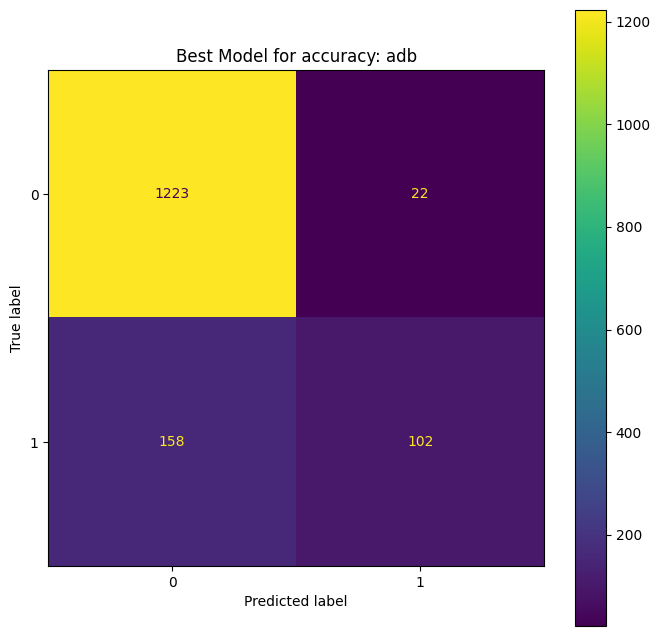

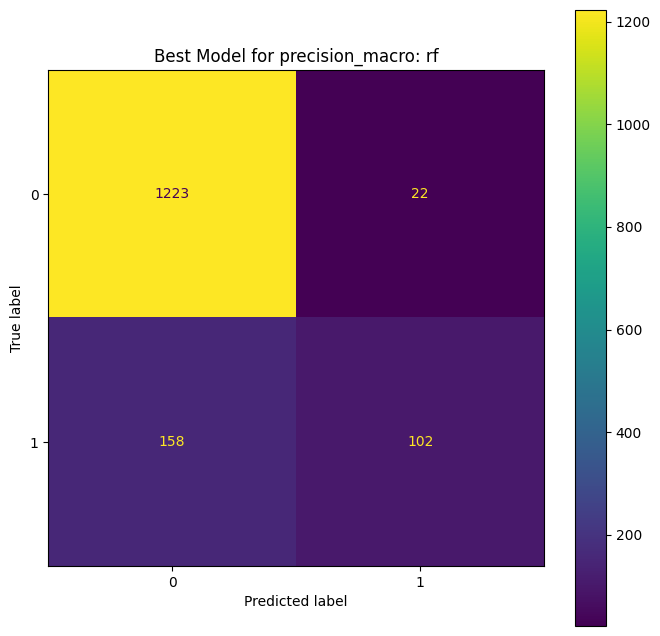

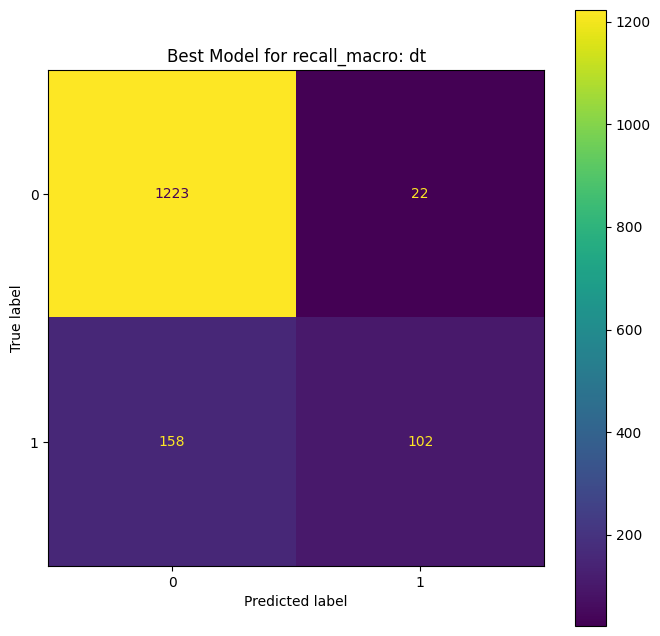

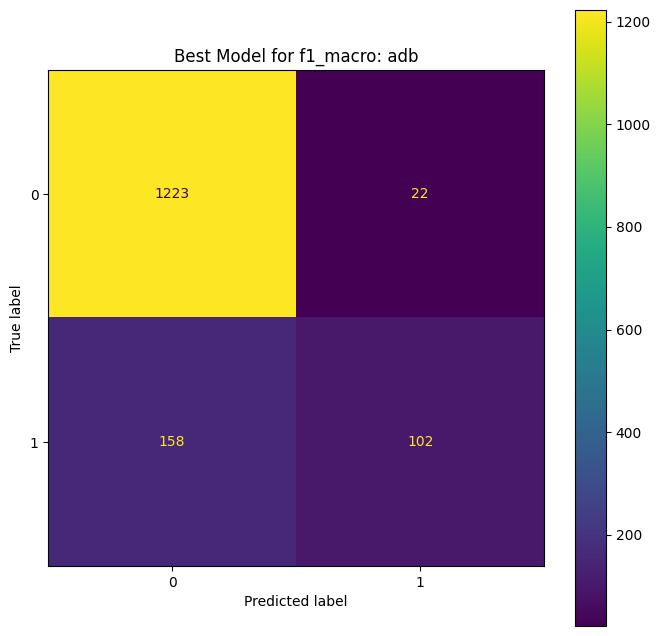

In [16]:
for score in scores:
    scoring_filter = results['scoring'] == score
    scoring_results = results[scoring_filter].sort_values(by=score, ascending=False)
    best_score = scoring_results.iloc[0]
    best_score_model_name = best_score['model']
    best_score_model_params = best_score['best_params']
    
    # Generate confusion matrix
    confusion_mat = confusion_matrix(ytest, y_pred)

    # Display the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    title = f'Best Model for {score}: {best_score_model_name}'
    ConfusionMatrixDisplay(confusion_mat).plot(ax=ax)
    ax.set_title(title)
    plt.show()